In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# classes and functions from 'util'
from util.data_load import returns_load
from util.GarchEstimator import GarchEstimator
from util.DescStat import DescStat
# from util.ANN_core import NeuralNetwork

In [3]:
from util.ANN_core import lLik

In [ ]:
np.random.seed(1995)

In [4]:
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'
garch_init = {
    'alpha' : 0.7,
    'beta1' : 0.3,
    'beta2' : 0.1,
    'omega1' : 0.01,
    'omega2' : 0.01,
    'omega3' : 0.01
}

In [5]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)

[*********************100%***********************]  1 of 1 completed


In [6]:
garch =  GarchEstimator(theta_init = garch_init)

In [7]:
ret_data['garch'] = garch.fit_data(
    method='GARCH',
    data_estimate=ret_data['return']*100,
    data_fit=ret_data['return']*100
    
)
print(garch.get_estimates(coef=True, llik=True))

`xtol` termination condition is satisfied.
Number of iterations: 465, function evaluations: 3038, CG iterations: 1361, optimality: 5.55e-04, constraint violation: 0.00e+00, execution time: 6.7e+02 s.
Model recalculated!
 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 1361
      cg_stop_cond: 4
            constr: [array([1.72537362e-01, 1.10906902e-01, 8.65658474e-02, 7.80671466e-06,
       4.79330203e-01, 2.81250032e-01])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 668.5757267475128
               fun: 9766.09531323833
              grad: array([-4.02832031e-03, -3.41796875e-03, -4.88281250e-03,  5.17895508e+00,
       -2.80761719e-03, -7.56835938e-03])
               jac: [<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-1.16451627e-04, -4.15315

C:\Users\sskor\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


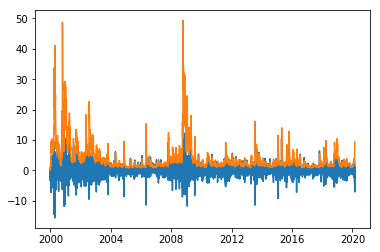

In [8]:
x = ret_data['dt']
y1 = ret_data['return']*100
y2 = ret_data['garch']
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [9]:
desc_obj = DescStat(data=ret_data['return']*100)

In [13]:
ret_data_enriched = pd.DataFrame({
    'dt': ret_data['dt'],
    'return100' : ret_data['return']*100,
    'garch': ret_data['garch'],
    'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
    'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
})

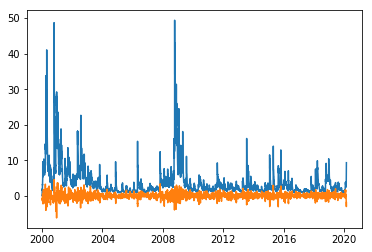

In [157]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = ret_data_enriched['garch']
y3 = ret_data_enriched['mean5_return100']
y4 = ret_data_enriched['var5_return100']
# plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

In [15]:
ret_data_enriched.head()

,dt,return100,garch,mean5_return100,var5_return100
0,2000-01-03,-0.160600,0.100000,-0.905444,5.344588
1,2000-01-04,-3.378016,0.100000,-0.905444,5.344588
2,2000-01-05,1.054384,0.100000,-0.905444,5.344588
3,2000-01-06,-3.349808,1.359696,-0.905444,5.344588
4,2000-01-07,1.306818,1.589353,-0.905444,5.344588


In [16]:
ret_data_enriched.shape

(5071, 5)

In [17]:
ret_data_enriched.dropna(inplace=True)
ret_data_enriched.shape

(5071, 5)

In [145]:
# =============================================================================
# define sigmoid function
# =============================================================================

def sigmoid(x):
    
    return 1/(1+ np.exp(-x))

# =============================================================================
# define sigmoid derivative function
# =============================================================================

def sigmoid_der(x):
    
#    return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# =============================================================================
# define log likelihood function
# =============================================================================

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

# =============================================================================
# define derivation of log likelihood
# =============================================================================

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

# =============================================================================
# define squared errors
# =============================================================================

def square_error(obs_val, obs_pred):
    
    return (obs_val - obs_pred) ** 2

# =============================================================================
# define first derivative of squared errors
# =============================================================================
    
#in this case should be multiplied by -1 since with respect to obs_pred, but then 
#change in weights and biases is not += but -=
def square_error_der(obs_val, obs_pred):
    
    return 2 * (obs_val - obs_pred)

# =============================================================================
# define linear function for case when only one layer
# =============================================================================
def linear(x):
    
    return x

# =============================================================================
# define derivative of linear 
# =============================================================================
def linear_der(x):
        
    return np.ones(x.shape)
# =============================================================================
# class object NeuralNetwork
# =============================================================================
    
class NeuralNetwork:

    def __init__(self, x, y, obj_fun = square_error, node_fun = linear,
                 hidden_layer = 1, step_rate = 0.001, bias = False, num_nodes = [1,0]):
        
        self.nodes1     = num_nodes[0]
        
        self.nodes2     = num_nodes[1]
        
        if obj_fun == square_error :
            
            self.obj_fun = square_error
            
            self.obj_fun_der = square_error_der
        
        elif obj_fun == lLik :
            
            self.obj_fun = lLik
            
            self.obj_fun_der = lLik_der
            
        else :
            
            print('set objective function to either squared errors or log-likelihood')
        
        self.input      = x
        
        self.y          = y

        self.output     = np.ones(self.y.shape)
        
        self.step_rate = step_rate
        
        self.bias = bias * 1
        
        if hidden_layer == 0 :
            
            self.weights_out = self.weights_hidden = np.ones([1,1])
            
            self.weights_input = np.random.rand(self.input.shape[1], 1)
            
            self.bias_out = self.bias_hidden = self.bias_input = np.zeros([1,1])
            
            self.node1_fun = linear
            
            self.node1_fun_der = linear_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
        
        elif hidden_layer == 1 :
            
            self.weights_out = np.ones([1,1])
            
            self.weights_hidden = np.random.rand(self.nodes1, 1)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = self.bias_hidden = np.zeros([1,1])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = sigmoid_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
            
        elif hidden_layer == 2 :
            
            self.weights_out = np.random.rand(self.nodes2, 1)
            
            self.weights_hidden = np.random.rand(self.nodes1, self.nodes2)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = np.zeros([1,1])
            
            self.bias_hidden = np.zeros([1, self.nodes2])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = self.node2_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = self.node2_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = self.node2_fun_der = sigmoid_der
                
            else:
                
                print('set the node function to either sigmoid or linear')
                
        else:
            
            print('set number of hidden layers to 0, 1 or 2')
            
    def feedforward(self):
        
        
        self.layer1 = self.node1_fun(np.dot(self.input, self.weights_input) + self.bias_input)
        
        self.layer2 = self.node2_fun(np.dot(self.layer1, self.weights_hidden) + self.bias_hidden)
        
        self.output = np.dot(self.layer2, self.weights_out) + self.bias_out
        
    def backprop(self):
        
        #calculate errors and partial derivatives
        
        error_out = self.obj_fun_der(self.y, self.output)
        
        print(error_out.head())
        
        d_weights_out = np.dot(self.layer2.T, error_out) 
        
        print(d_weights_out)
        
        error_hidden = np.dot(error_out, self.weights_out.T) * self.node2_fun_der(self.layer2) # this is derivative in terms of f(x) maybe should change to derivative in terms of x, then it needs to be layer1*weights_hidden
        
        print(error_hidden[1:5])
        
        d_weights_hidden = np.dot(self.layer1.T, error_hidden) 
        
        print(d_weights_hidden)
        
        error_input = np.dot(error_hidden, self.weights_hidden.T) * self.node1_fun_der(self.layer1)
        
        print(error_input[1:5])
        
        d_weights_input = np.dot(self.input.T, error_input)
        
        print(d_weights_input)
        
        d_bias_out = np.dot(np.ones(self.output.shape[0]), error_out) 
        
        d_bias_hidden = np.dot(np.ones(self.layer2.shape[0]), error_hidden)
        
        d_bias_input = np.dot(np.ones(self.input.shape[0]), error_input)
        
        #update weights and biases
        
        self.weights_out += d_weights_out * self.step_rate * (self.nodes2 > 0)
        
        self.weights_hidden += d_weights_hidden * self.step_rate * (self.nodes1 > 0) 
        
        self.weights_input += d_weights_input * self.step_rate
        
        self.bias_out += d_bias_out * self.step_rate * self.bias * (self.nodes2 > 0)
        
        self.bias_hidden += d_bias_hidden * self.step_rate * self.bias * (self.nodes1 > 0)
        
        self.bias_input += d_bias_input * self.step_rate * self.bias
    
    def cost(self):
        return np.sum(self.obj_fun(self.y, self.output))
    def get_output(self):
        return self.output
        
    def get_observed(self):
        return self.y
    def get_layer1(self):
        return self.layer1
    def get_layer2(self):
        return self.layer2
    def get_weights(self):
        return [self.weights_input, self.weights_hidden, self.weights_out]
    def get_input(self): 
        return self.input
#    def change_data(self, new_x, new_y):
#        self.x = new_x
#        self.y = new_y


In [168]:
NN_obj = NeuralNetwork(
    x=ret_data_enriched.iloc[:,2:5],
    y=ret_data_enriched.iloc[:,1:2],
    obj_fun=lLik,
    hidden_layer=0,
    node_fun=linear,
    num_nodes=[0,0]
)

In [169]:
NN_obj.feedforward()
for i in range(200) :
        NN_obj.backprop()
        NN_obj.feedforward()

   return100
0  -0.241939
1  -0.079969
2  -0.226490
3  -0.084226
4  -0.216672
[[6277981.44214005]]
[[-0.07996942]
 [-0.22649037]
 [-0.08422561]
 [-0.21667236]]
[[6277981.44214005]]
[[-0.07996942]
 [-0.22649037]
 [-0.08422561]
 [-0.21667236]]
[[-2.41066564e+10]
 [ 6.39388226e+09]
 [-4.56555731e+09]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-0

 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e

[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.588

[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.588

[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.588

      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392

[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[1.85939875e-04]
 [6.79307981e-06]
 [1.38437780e-04]]
      return100
0  3.067392e-08
1  3.067392e-08
2  3.067392e-08
3  1.588107e-08
4  1.459762e-08
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.58810684e-08]
 [1.45976204e-08]]
[[-5071.]]
[[3.06739188e-08]
 [3.06739188e-08]
 [1.588

In [170]:
NN_obj.get_weights()

[array([[-24106656.33792282],
        [  6393882.98717925],
        [ -4565556.41182506]]), array([[1.]]), array([[1.]])]

In [171]:
np.var(ret_data_enriched['return100']*100)

36241.03527379791

In [172]:
max(NN_obj.get_output())

array([-20976699.3146335])

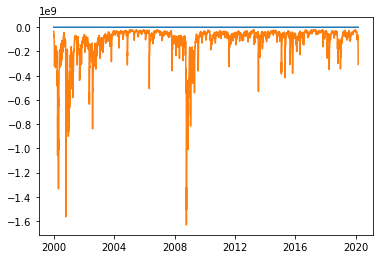

In [173]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output()
plt.plot(x, y1)
plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

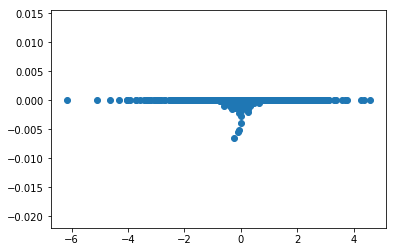

In [134]:
x = ret_data_enriched['mean5_return100']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

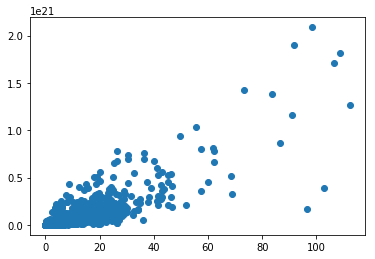

In [37]:
x = ret_data_enriched['var5_return100']
y1 = NN_obj.get_output()**2
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

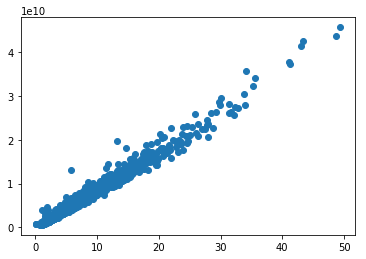

In [38]:
x = ret_data_enriched['garch']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

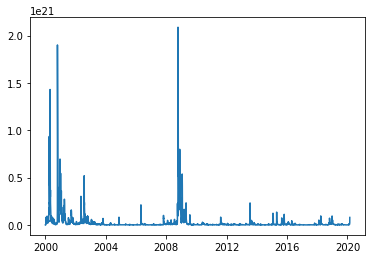

In [39]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output() ** 2

plt.plot(x, y2)
plt.show()

In [41]:
NN_obj.get_weights()

[array([[ 1611837.73953872,   792260.24165044,  3004553.48070382,
          2317186.63723816,    26113.79160933],
        [ -636672.50907852,  -312940.81757742, -1186793.19034473,
          -915284.50135104,   -10314.20258629],
        [  218095.67899916,   107199.74056005,   406542.79422921,
           313535.79090393,     3534.01724127]]), array([[-386882.25280562],
        [ 250766.54755467],
        [ 354540.75900508],
        [-298564.0318481 ],
        [2000590.27145576]]), array([[1.]])]